In [15]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
from slsim.Plots.lens_plots import LensingPlots
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import corner

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

Load `skypy` configuration file

In [16]:
import mejiro
module_path = os.path.dirname(mejiro.__file__)
skypy_config = os.path.join(module_path, 'data', 'hwo.yml')

Load Euclid VIS filter response curve

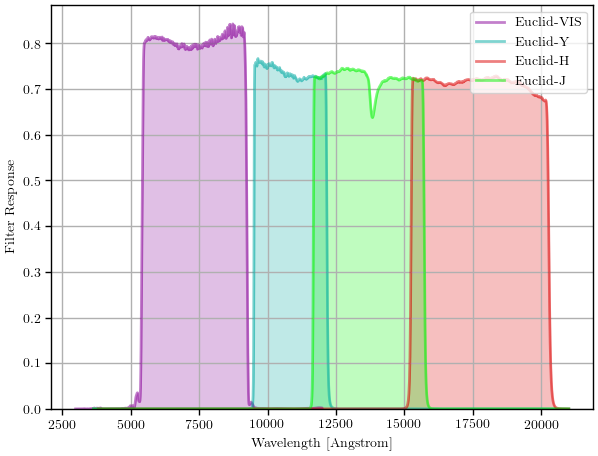

In [17]:
euclid = speclite.filters.load_filters('Euclid-VIS', 'Euclid-Y', 'Euclid-H', 'Euclid-J')
speclite.filters.plot_filters(euclid)

In [18]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.5, unit="deg2")

kwargs_deflector_cut = {
    # 'band': 'VIS',
    # 'band_max': 25,
    'z_min': 0.01,
    'z_max': 2.
}
kwargs_source_cut = {
    # 'band': 'VIS',
    # 'band_max': 28,
    'z_min': 0.01,
    'z_max': 5.
}

# run skypy pipeline and make galaxy-galaxy population class
lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [19]:
kwargs_lens_cut = {
    'min_image_separation': 0.2,
    'max_image_separation': 10,
    'mag_arc_limit': {'VIS': 25}
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

ValueError: required parameter is missing in the source dictionary.

In [ ]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="F184")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

In [ ]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()